In [1]:
import math
import tensorflow as tf
import numpy as np

from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [2]:
import matplotlib.pyplot as plt

In [3]:
import json
import shap
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [4]:
tf.app.flags.DEFINE_string('f', None, '')

In [5]:
import eval_image_classifier

In [6]:
slim = tf.contrib.slim
FLAGS = tf.app.flags.FLAGS

In [7]:
FLAGS.batch_size = 4
FLAGS.dataset_name = 'imagenet'
FLAGS.dataset_split_name = 'validation'
FLAGS.dataset_dir = '/data/image_datasets/imagenet/'
FLAGS.eval_image_size = 299
FLAGS.model_name = 'inception_v4'
FLAGS.checkpoint_path = 'inception_v4.ckpt'

In [8]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf_global_step = slim.get_or_create_global_step()

######################
# Select the dataset #
######################
dataset = dataset_factory.get_dataset(
    FLAGS.dataset_name, FLAGS.dataset_split_name, FLAGS.dataset_dir)

####################
# Select the model #
####################
network_fn = nets_factory.get_network_fn(
    FLAGS.model_name,
    num_classes=(dataset.num_classes - FLAGS.labels_offset),
    is_training=False)

##############################################################
# Create a dataset provider that loads data from the dataset #
##############################################################
provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset,
    shuffle=False,
    common_queue_capacity=2 * FLAGS.batch_size,
    common_queue_min=FLAGS.batch_size)
[image, label] = provider.get(['image', 'label'])
label -= FLAGS.labels_offset

#####################################
# Select the preprocessing function #
#####################################
preprocessing_name = FLAGS.preprocessing_name or FLAGS.model_name
image_preprocessing_fn = preprocessing_factory.get_preprocessing(
    preprocessing_name,
    is_training=False)

eval_image_size = FLAGS.eval_image_size or network_fn.default_image_size

image = image_preprocessing_fn(image, eval_image_size, eval_image_size)

images, labels = tf.train.batch(
    [image, label],
    batch_size=FLAGS.batch_size,
    num_threads=FLAGS.num_preprocessing_threads,
    capacity=5 * FLAGS.batch_size)

####################
# Define the model #
####################
images_pl = tf.placeholder(tf.float32, (None, 299, 299, 3))
logits, _ = network_fn(images_pl)
pred_labels   = tf.argmax(logits, axis=1)

variables_to_restore = slim.get_variables_to_restore()

In [9]:
tf.logging.set_verbosity(tf.logging.INFO)

In [10]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [11]:
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(coord=coord, sess=sess)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [12]:
saver = tf.train.Saver(variables_to_restore)

In [13]:
saver.restore(sess, FLAGS.checkpoint_path)

INFO:tensorflow:Restoring parameters from inception_v4.ckpt


In [14]:
def normalize(im_batch):
    max_vals = np.amax(im_batch, axis=(1,2,3), keepdims=True)
    min_vals = np.amin(im_batch, axis=(1,2,3), keepdims=True)
    return (im_batch - min_vals) / (max_vals - min_vals)

In [19]:
im_final = []
labels_final = []
logits_final = []

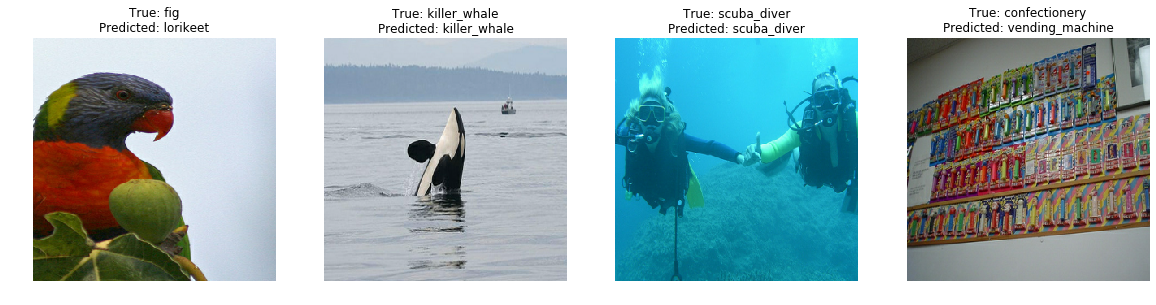

In [41]:
im_batch, label_batch = sess.run([images, labels])

pred_batch, pred_logits = sess.run([pred_labels, logits], feed_dict={images_pl: im_batch})
norm_im_batch = normalize(im_batch)
true_names = np.vectorize(lambda x: class_names[str(x)][1])(label_batch - 1)
pred_names = np.vectorize(lambda x: class_names[str(x)][1])(pred_batch - 1)

num_images = norm_im_batch.shape[0]
fig, axs = plt.subplots(1, num_images, figsize=(20, 20*num_images))
for i in range(num_images):
    axs[i].imshow(norm_im_batch[i])
    axs[i].axis('off')
    axs[i].set_title('True: {}\nPredicted: {}'.format(true_names[i], pred_names[i]))

In [42]:
im_final.append(im_batch[1])
labels_final.append(label_batch[1])
logits_final.append(pred_logits[1])

In [45]:
im_final = np.array(im_final)
labels_final = np.array(labels_final)
logits_final = np.array(logits_final)

In [48]:
pred_final = np.argmax(logits_final, axis=1)

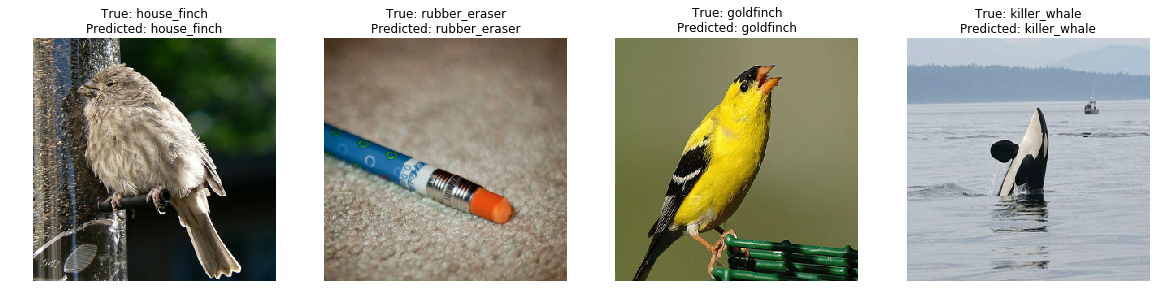

In [50]:
true_names = np.vectorize(lambda x: class_names[str(x)][1])(labels_final - 1)
pred_names = np.vectorize(lambda x: class_names[str(x)][1])(pred_final - 1)

norm_im_batch = normalize(im_final)
num_images = norm_im_batch.shape[0]
fig, axs = plt.subplots(1, num_images, figsize=(20, 20*num_images))
for i in range(num_images):
    axs[i].imshow(norm_im_batch[i])
    axs[i].axis('off')
    axs[i].set_title('True: {}\nPredicted: {}'.format(true_names[i], pred_names[i]))

In [53]:
np.save('data/images.npy', im_final)
np.save('data/labels.npy', labels_final)
np.save('data/logits.npy', logits_final)